# Producing a matrix of weightings vs. scores

The goal of this notebook is to cleanly produce a file containing a matrix of weightings and scores. For now, the score will be a mean absolute error (MAE). More data is required to implement a more robust score (ex. CRPS).

### 1. Necessary imports

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt

In [2]:
PATH = "./home/wxprediction_gmail_com/Data_ForecastContest/FTP/"

#### File naming conventions:

* archive_Fcst.csv, archive_ID.csv, archive_Sigma.csv - not sure 
* CFS.csv - looks like the most recent CFS forecast (2019-09-16)
* CFS_20190528.csv - forecast for a given date
* ECMWF.csv - looks like the most recent EC forecast (2019-09-12)
* ECMWF_20190528.csv - EC forecast for a given date
* wdd.daily.20190326.csv - a file containng verification (for dates previous?)

### 2. Important Functions (made)

Noting file structure - Important Columns:
1. model_date (contains initialization date)
2. fday (contains the day of the forecast (day 0, day 1, etc.)
3. verif_date (contains verification date)
4. value (contains HDD value)
5. normal_10y, normal_30y (climatology values)

note: both files have the same structure

note: both files contain separate sections for HDDs and CDDs

In [3]:
"""
This function reads in data from the file of ECMWF forecasts. 
It selects the forecast days of interest (for a given parameter) - default is CDDs.
It then returns the predicted value, the climo values for the forecast period, and the dates.
"""

def read_ecmwf(ec_file, param = "CDD"):
    isel_fdays = np.logical_and(ec_file['fday'] >= 16, ec_file['fday'] <= 20)
    isel_params = ec_file['param'] == param
    isel = np.logical_and(isel_fdays, isel_params)

    ec_values = ec_file['value'][isel]
    climo_10y = ec_file['normal_10y'][isel]
    climo_30y = ec_file['normal_30y'][isel]

    ec_predicted_value = np.sum(ec_values)
    cl10_predicted_value = np.sum(climo_10y)
    cl30_predicted_value = np.sum(climo_30y)
    dates = ec_file['verif_date'][isel]
    
    return (ec_predicted_value, cl10_predicted_value, cl30_predicted_value, dates)

"""
This function reads in data from the file of CFS forecasts. 
It selects the forecast days of interest (for a given parameter) - default is CDDs.
It then returns the predicted value. It does not return anything else, as the EC function already does that.
"""

def read_cfs(cfs_file, param = "CDD"):
    isel_fdays = np.logical_and(cfs_file['fday'] >= 16, cfs_file['fday'] <= 20)
    isel_params = cfs_file['param'] == param
    isel = np.logical_and(isel_fdays, isel_params)

    cfs_values = cfs_file['value'][isel]

    cfs_predicted_value = np.sum(cfs_values)
    return cfs_predicted_value

"""
This function reads in observations corresponding to a series of dates. 
It accepts a list of dates corresponding the forecast days of interest.
It then formats the dates to the file convention, opens the file for each date, and collects the value of a given parameter.
It then returns the observed value.
"""

def read_obs(dates, param = "CDD"):
    dates = np.array(dates)

    verif_values = []

    i = 0
    while i < len(dates):
        d_str = dates[i]
        d_dt = datetime.strptime(dates[i],"%Y-%m-%d")
        d_dt = d_dt + timedelta(days = 1)
        f_string = datetime.strftime(d_dt, "%Y%m%d")
        verif_file = pd.read_csv(PATH+"wdd.daily."+f_string+".csv")

        isel = np.logical_and(verif_file['DATE'] == d_str, verif_file['PARAM'] == param)
        verif_values.append(verif_file['VALUE'][isel].values)
        i = i+1

    verif_value = np.sum(verif_values)
    
    return verif_value

### 3. Loading in data for a subset of dates

Here we load in the data for the datese we have. Note that we first have to preprocess the dates to only include the dates where both the CFS and ECMWF are available (Monday and Thursday). We then access all of the data for these dates, and store it in master_dataframe


In [4]:
PATH = "./home/wxprediction_gmail_com/Data_ForecastContest/FTP/"

cfs_vals = []
ecmwf_vals = []
c10_vals = []
c30_vals = []
verif_vals = []
date_list = []


#Selecting the start and end dates:
start = datetime(2019, 6, 2)
end = datetime(2019, 8, 27)
delta = timedelta(days=1)

#Looping through all of the dates, accessing the files, and storing data
d = start
diff = 0
valid_dates = set([0, 3])
while d <= end:
    if d.weekday() in valid_dates:
        
        date_list.append(d)
        
        f_string = datetime.strftime(d, "%Y%m%d")
        
        #loading ECMWF file
        ec_file = pd.read_csv(PATH+"ECMWF_"+f_string+".csv")
        cfs_file = pd.read_csv(PATH+"CFS_"+f_string+".csv")
        ec_val, c10_val, c30_val, dates = read_ecmwf(ec_file)
        cfs_val = read_cfs(cfs_file)
        verif_val = read_obs(dates)
        
        cfs_vals.append(cfs_val)
        ecmwf_vals.append(ec_val)
        c10_vals.append(c10_val)
        c30_vals.append(c30_val)
        verif_vals.append(verif_val)
        
    d += delta

    
#Formatting data into dataframe
data = {'CFS':cfs_vals, 'ECMWF':ecmwf_vals, '10y_climo':c10_vals, '30y_climo':c30_vals, 'Verif':verif_vals}

master_dataframe = pd.DataFrame(data, index = date_list)

### 4. Calculating performance based on weightings

Here we calculate predetermined weightings and calculate the MAE for all combinations. Here, we use two weightings. The MAE calculated is simply the mean MAE - this may not be the best metric for transition seasons. It may be useful to calculate a standardized MAE (standardized by the typical CDDs/HDDs?). 

The result of this code block is to output a csv file that could be queried to determine the best weightings. 

In [5]:
cfs_weight = np.arange(0,1.01,0.01)
ecmwf_weight = 1-cfs_weight
weighting_maes = np.zeros(shape = np.shape(cfs_weight))

i = 0
for cw, ew in zip(cfs_weight, ecmwf_weight):
    weighting_prediction = cw*master_dataframe['CFS']+ew*master_dataframe['ECMWF']
    weighting_maes[i] = np.mean(np.abs(weighting_prediction - master_dataframe['Verif']))
    i = i+1
    
perf_data = {'CFS_Weight':cfs_weight, 'ECMWF_Weight':ecmwf_weight,'MAE':weighting_maes}
performance_dataframe = pd.DataFrame(perf_data)

#out = performance_dataframe.to_csv(r'mae_by_weights.csv', header = True)

What if we wanted to expand this to three inputs?

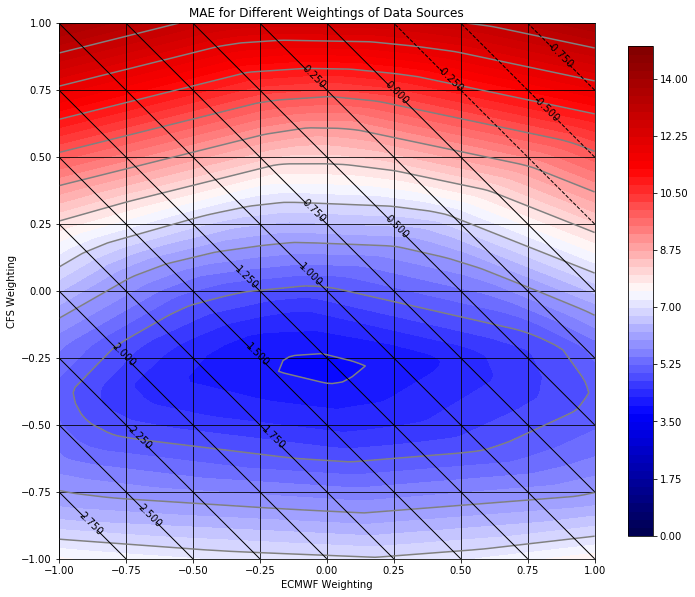

In [6]:
min = -1
skip = 0.02

cfs_weight = np.arange(min,1.01,skip)
ecmwf_weight = np.arange(min,1.01,skip)
weighting_maes = np.zeros(shape = (np.shape(cfs_weight)[0], np.shape(ecmwf_weight)[0]))
climo_weight = np.zeros(shape = (np.shape(cfs_weight)[0], np.shape(ecmwf_weight)[0]))

i = 0
for cw in cfs_weight:
    j = 0
    for ew in ecmwf_weight:
        c10_weight = 1-(cw+ew)
        weighting_prediction = cw*master_dataframe['CFS']+ew*master_dataframe['ECMWF']+c10_weight*master_dataframe['10y_climo']
        wm = np.mean(np.abs(weighting_prediction - master_dataframe['Verif']))
        weighting_maes[i,j] = wm
        climo_weight[i,j] = c10_weight
        j = j+1
    i = i+1

plt.figure(figsize = (12,12))
plt.axis('scaled')
plt.title("MAE for Different Weightings of Data Sources")

cint = np.arange(0, 15.1, 0.25)
cint_c = np.arange(0,15.1,1.0)
CF = plt.contourf(ecmwf_weight, cfs_weight, weighting_maes, levels = cint, cmap = 'seismic')
plt.contour(ecmwf_weight, cfs_weight, weighting_maes, levels = cint_c, colors = 'gray')
CS = plt.contour(ecmwf_weight, cfs_weight, climo_weight, levels = np.arange(-3, 3.01, 0.25), linewidths = 1.0, colors = 'black')
plt.clabel(CS, inline = True)
plt.xlabel('ECMWF Weighting')
plt.ylabel('CFS Weighting')

plt.xlim([-1,1])
plt.ylim([-1,1])

plt.grid(color = 'black')
plt.colorbar(CF, shrink = 0.75)

plt.show()

### 5. Calculating performance for user-specified weightings

The above code block represents the inflexible version - automatically calculating the performance of a given weighting scheme for two variables. This code block will attempt to streamline this by using user-defined weightings for any number of inputs (3 for now, but reasonably easy to expand)

In [7]:
#### USER INPUTS:
CFS_WEIGHT = -0.2
ECMWF_WEIGHT = 0.4
CLIMO_WEIGHT = 0.8

WEIGHTING_PREDICTION = CFS_WEIGHT*master_dataframe['CFS']+ECMWF_WEIGHT*master_dataframe['ECMWF']+CLIMO_WEIGHT*master_dataframe['10y_climo']
MAE = np.mean(np.abs(WEIGHTING_PREDICTION - master_dataframe['Verif']))

print("MAE for CDDs for %.2f CFS, %.2f ECMWF, %.2f 10 year Climatology Weighting: %.2f" % (CFS_WEIGHT, ECMWF_WEIGHT, CLIMO_WEIGHT, MAE))

MAE for CDDs for -0.20 CFS, 0.40 ECMWF, 0.80 10 year Climatology Weighting: 4.41


We can now easily plot the prediction, observations, climo, and model projections:

/kt11/ktyle/anaconda3_201903/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


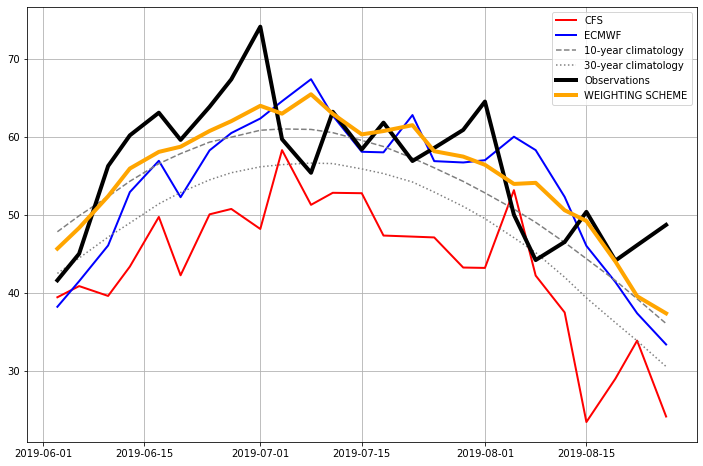

In [8]:
plt.figure(figsize = (12,8))

plt.plot(master_dataframe['CFS'], color = 'red', linewidth = 2.0, label = 'CFS')
plt.plot(master_dataframe['ECMWF'], color = 'blue', linewidth = 2.0, label = 'ECMWF')
plt.plot(master_dataframe['10y_climo'], '--', color = 'gray', label = '10-year climatology')
plt.plot(master_dataframe['30y_climo'], ':', color = 'gray', label = '30-year climatology')
plt.plot(master_dataframe['Verif'], color = 'black', linewidth = 4.0, label = 'Observations')
plt.plot(WEIGHTING_PREDICTION, color = 'orange', linewidth = 4.0, label = 'WEIGHTING SCHEME')

plt.grid()
plt.legend()
plt.show()